In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [16]:
%matplotlib inline

from sessions import selected_008229, selected_013608, selected_013829
from imports import *
from scipy import stats

from spiketrain import inst_rate

In [17]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Create ensembles and dump them to H5

In [18]:
#source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'

ensemble_units = {
    '013608_ppcSIT_2025-01-14_10-20-14': ['2-142', '2-234', '3-217', '4-198'],
    '013608_ppcSIT_2025-01-15_14-56-18': ['2-166', '2-288', '3-258', '4-231'],
    '013608_ppcSIT_2025-01-20_09-38-20': ['2-160', '2-241', '3-221', '4-201'],
    '013608_ppcSIT_2025-01-23_08-46-51': ['2-171', '2-279', '3-252', '4-234'],
    '013608_ppcSIT_2025-01-27_09-00-20': ['2-282', '2-355'],
    '013608_ppcSIT_2025-01-29_12-34-08': ['2-322', '2-408', '4-371'],
    '013608_ppcSIT_2025-02-18_14-15-52': ['2-147', '2-242', '3-221'],
    '013608_ppcSIT_2025-02-27_08-56-52': ['2-398', '2-485'],
    '013608_ppcSIT_2025-02-28_16-23-29': ['2-301', '2-377'],
    '013608_ppcSIT_2025-03-03_08-55-30': ['2-302', '2-388'],
    '013608_ppcSIT_2025-03-04_09-17-16': ['2-314', '2-380'],
    '013608_ppcSIT_2025-03-05_10-33-41': ['2-307', '2-392']
}

In [93]:
for session, ensemble_ids in ensemble_units.items(): 
    animal = session.split('_')[0]

    s_path     = os.path.join(source, animal, session)
    meta_file  = os.path.join(s_path, 'meta.h5')
    unit_file  = os.path.join(s_path, 'units.h5')

    # read data
    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        events = np.array(f['processed']['sound_events'])
        trials = np.array(f['processed']['trial_idxs'])
        
    spike_times = {}
    with h5py.File(unit_file, 'r') as f:
        for unit_name in ensemble_ids:
            spike_times[unit_name]  = np.array(f[unit_name][H5NAMES.spike_times['name']])
            
    # build ensemble. 250 - 300 ms give the best bimodality
    ensemble_mx = np.zeros([len(ensemble_ids), len(tl)])
    for i, unit_id in enumerate(ensemble_ids):
        ensemble_mx[i] = inst_rate(spike_times[unit_id], tl[:, 0], k_width=250)
        ensemble_mx[i] = stats.zscore(ensemble_mx[i])

    # speed correlation
    sp_corr = np.corrcoef(ensemble_mx.mean(axis=0), tl[:, 3])[0][1]

    # dump to H5
    ensembles_f = os.path.join(s_path, 'analysis', 'ensembles.h5')
    with h5py.File(ensembles_f, 'w') as f:
        ds = f.create_dataset('AL', data=ensemble_mx.mean(axis=0))
        ds.attrs['speed_corr'] = sp_corr

## Plot some ensemble

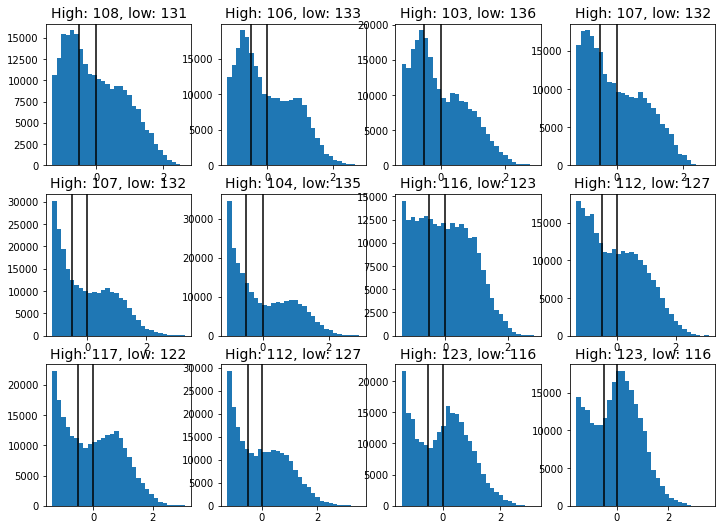

In [99]:
cols = 4
rows = int(len(ensemble_units)/cols) + 1

fig = plt.figure(figsize=(cols*3, rows*3))

for i, session in enumerate(ensemble_units.keys()):
    animal = session.split('_')[0]
    s_path = os.path.join(source, animal, session)
    ense_file = os.path.join(s_path, 'analysis', 'ensembles.h5')
    with h5py.File(ense_file, 'r') as f:
        ens = np.array(f['AL'])

    ax = fig.add_subplot(rows, cols, i+1)
    ax.hist(ens, bins=30)
    ax.axvline(0, color='black')
    ax.axvline(-0.5, color='black')
    
    idxs_high = np.where(ens > 0)[0]
    idxs_low  = np.where(ens < 0)[0]
    ax.set_title(f"High: {int(len(idxs_high)/1000)}, low: {int(len(idxs_low)/1000)}", fontsize=14)

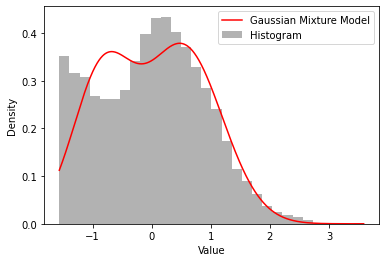

Component 1: Mean = 0.54, Std Dev = 0.66, Weight = 0.61
Component 2: Mean = -0.84, Std Dev = 0.50, Weight = 0.39


In [105]:
from sklearn.mixture import GaussianMixture

data = ens.reshape(-1, 1)

# Fit a Gaussian Mixture Model with 2 components
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(data)

# Get the estimated means and covariances
means = gmm.means_.flatten()
std_devs = np.sqrt(gmm.covariances_).flatten()
weights = gmm.weights_

# Plot the histogram of the data
x = np.linspace(min(data), max(data), 1000).reshape(-1, 1)
pdf = np.exp(gmm.score_samples(x))

plt.hist(data, bins=30, density=True, alpha=0.6, color='gray', label='Histogram')
plt.plot(x, pdf, label='Gaussian Mixture Model', color='red')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

# Print the parameters
for i in range(2):
    print(f'Component {i+1}: Mean = {means[i]:.2f}, Std Dev = {std_devs[i]:.2f}, Weight = {weights[i]:.2f}')

## Plot ensembe in time

In [94]:
session = '013608_ppcSIT_2025-02-27_08-56-52'

animal = session.split('_')[0]

s_path     = os.path.join(source, animal, session)
meta_file  = os.path.join(s_path, 'meta.h5')
unit_file  = os.path.join(s_path, 'units.h5')
ense_file  = os.path.join(s_path, 'analysis', 'ensembles.h5')

# read data
with h5py.File(meta_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])
    tgt_mx = np.array(f['processed']['target_matrix'])
    events = np.array(f['processed']['sound_events'])
    trials = np.array(f['processed']['trial_idxs'])
    
with h5py.File(ense_file, 'r') as f:
    ens = np.array(f['AL'])

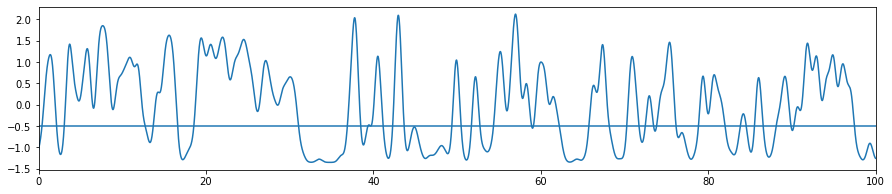

In [76]:
t1, t2 = 0, 100
s_rate = 100  # Hz, everything is timeline sampled

fig, ax = plt.subplots(1, 1, figsize=(15, 3))

x_vals = np.arange((t2-t1)*s_rate)/s_rate
ax.plot(x_vals, ens[t1*s_rate:t2*s_rate])
ax.set_xlim(t1, t2)
ax.axhline(-0.5)